In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import logging

In [2]:
file_path = 'productos_anaquel.xls'
df_ = []
i = 1

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.FileHandler('log.txt')
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.info('Reading file...')

try:
    while True:
        df_.append(pd.read_excel(file_path, sheet_name=f"Sheet {i}"))
        i += 1
except:
    pass

df_ = pd.concat(df_, ignore_index=True)
df = df_[df_['ANAQUEL'].str.startswith('C', na=False)]
df = df[df['CAMPA'] == 201416]
df.reset_index(drop=True, inplace=True)

WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (65174245) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [3]:
df

CAMPA   PRODUCTO                          NOMBRE  ALTO  ANCHO  LARGO  \
0    201416  200063628  ES WINNERBLACK PROB C/C 4.5 ML  1.45    6.0   1.45   
1    201416  200063636   ES L'IMAGE LOC PERF CC 150 ML  4.90   15.4   7.70   
2    201416  200063644  ES L'IMAGE DIA LOC PERF 150 ML  4.90   15.0   7.70   
3    201416  200063815      CZ LL LARG DUR X-TRA PEACH  2.20    6.7   2.20   
4    201416  200063818      CZ LL LARG DUR X-TRA APPLE  2.20    6.7   2.20   
..      ...        ...                             ...   ...    ...    ...   
621  201416  210066588  CY TEM COOL HEARTS BLANCO N XL  1.40   24.0  20.50   
622  201416  210066846        CY TWIST BIKINI MORADO S  4.50   19.4  17.30   
623  201416  210066847        CY TWIST BIKINI MORADO M  4.50   19.4  17.30   
624  201416  210067101    CY0712 SOFA SIT CHILL FLORES  5.20   19.3  15.00   
625  201416  210067410  ESIKA ACC TOO COOL EST ARET X3  2.30    8.1   5.60   

     VOLUMEN    PESO  CODNEGOCIO          NOMBRENEGOCIO ANAQUEL  UNDESTIMADAS  \
0      12.62   10.76         101             FRAGANCIAS   C02A4          4371   
1     581.04  174.26         105  TRATAIMIENTO CORPORAL   C21C6          2277   
2     565.95  177.28         105  TRATAIMIENTO CORPORAL   C27C1          1212   
3      32.43   16.10         102             MAQUILLAJE   C02B6          1514   
4      32.43   16.18         102             MAQUILLAJE   C01A1          2569   
..       ...     ...         ...                    ...     ...           ...   
621   688.80   93.42         301                   ROPA   C24A3            47   
622  1510.29   99.94         301                   ROPA   C14A1           240   
623  1510.29  101.92         301                   ROPA   C22A1           239   
624  1505.40  632.14         401                  HOGAR   C18B3           488   
625   104.33   14.14         201              BIJOUTERI   C09C1           436   

     UNDFACTURADASULTDIA  UNDFACTURADASCAMPA  
0                     33                2103  
1                      7                3524  
2                      3                1727  
3                      4                 513  
4                      8                1727  
..                   ...                 ...  
621                    0                  29  
622                    1                 168  
623                    1                 153  
624                    1                 436  
625                    4                1525  

[626 rows x 14 columns]

In [ ]:
# Environment Definition
class AnaquelEnv:
    def __init__(self, df, zones=9, anaqueles_per_zone=4, rows=3, cols=7):
        self.df = df.copy()
        self.df_iterations = df.copy()
        self.zones = zones
        self.anaqueles_per_zone = anaqueles_per_zone
        self.rows = rows
        self.cols = cols

        self.state_quantities = np.zeros((zones, anaqueles_per_zone, rows, cols))  # Matrix of quantities
        
        self.num_products = df['PRODUCTO'].unique()
        self.product_id_to_index = {pid: idx for idx, pid in enumerate(self.num_products)}

        self.state_products = np.full((zones, anaqueles_per_zone, rows, cols), fill_value=-1, dtype=int)  # Matrix of product IDs
        
        self.action_space = zones * anaqueles_per_zone * rows * cols  # Possible placements

        self.state_products_onehot = np.zeros((zones, anaqueles_per_zone, rows, cols, len(self.num_products)))

    def reset(self):
        self.df_iterations = self.df.copy()
        self.state_quantities = np.zeros((self.zones, self.anaqueles_per_zone, self.rows, self.cols))
        self.state_products = np.full((self.zones, self.anaqueles_per_zone, self.rows, self.cols), fill_value=-1, dtype=int)

        self.state_products_onehot.fill(0)

        return self.state_quantities, self.state_products_onehot
    
    def step(self, action):
        item = self.df_iterations.sample()
        product_id = item['PRODUCTO'].values[0]
        quantity = item['UNDESTIMADAS'].values[0]

        if product_id not in self.product_id_to_index:
            raise ValueError(f"Product ID {product_id} not found in mapping")

        product_index = self.product_id_to_index[product_id]  # Get valid index

        zone, anaquel, row, col = action
        if self.state_products[zone, anaquel, row, col] == -1:  # Empty cell
            #print(f"  Placing {product_id} in Zone {zone}, Anaquel {anaquel}, Row {row}, Col {col}")
            self.state_products[zone, anaquel, row, col] = product_id  # Assign product ID
            self.state_quantities[zone, anaquel, row, col] = quantity  # Assign quantity
            self.df_iterations = self.df_iterations[self.df_iterations['PRODUCTO'] != product_id]
            
            self.state_products_onehot[zone, anaquel, row, col, product_index] = 1
            

            reward = self.compute_reward()
            done = self.is_done()

            if self.df_iterations.empty:
                done = True
            return (self.state_quantities, self.state_products), reward, done
        return (self.state_quantities, self.state_products), -5000, False  # Invalid action penalty
    
    def compute_reward(self):
        # Reward function for balancing zones and prioritizing high UNDESTIMADAS in front
        zone_totals = np.sum(self.state_quantities, axis=(1, 2, 3))  # Sum of products in each zone
        zone_balance = -np.std(zone_totals)  # Minimize standard deviation for balance
        front_anaqueles = self.state_quantities[:, 1::2, :, :]  # Even-numbered Anaqueles
        front_priority = np.sum(front_anaqueles)  # Encourage more products in front Anaqueles
        back_anaqueles = self.state_quantities[:, 0::2, :, :]  # Odd-numbered Anaqueles
        #print(f"  Front Anaqueles: {front_anaqueles} | Back Anaqueles: {back_anaqueles}")
        back_penalty = np.sum(back_anaqueles)  # Penalize products in back Anaqueles
        #print(f"  Zone Balance: {zone_balance} | Front Priority: {front_priority}")
        return zone_balance * 0.7 + (front_priority - back_penalty * 3) * 0.3
    
    def is_done(self):
        return np.all(self.state_products != -1)  # Done when all cells are filled

# Neural Network Policy
class RLAgent(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RLAgent, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        temperature = 0.8  # Adjust based on behavior
        return torch.softmax(self.fc4(x) / temperature, dim=-1)




# Training Loop
env = AnaquelEnv(df)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_products = len(env.num_products)  # Get the number of unique products

input_dim = (
    env.zones * env.anaqueles_per_zone * env.rows * env.cols
) * (1 + num_products)  # 1 for state_quantities, num_products for one-hot encoding

agent = RLAgent(input_dim=input_dim, output_dim=env.action_space).to(device)
optimizer = optim.Adam(agent.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

episodes = 100

losses = []
rewards = []

for episode in tqdm(range(episodes)):
    state_quantities, state_products_onehot = env.reset()
    done = False
    episode_loss = 0
    episode_reward = 0
    while not done:
        state_tensor = torch.tensor(
            np.concatenate((state_quantities.flatten(), state_products_onehot.flatten())), 
            dtype=torch.float32
        ).to(device)


        # Use no_grad() only for selecting actions, not for training
        with torch.no_grad():
            action_probs = agent(state_tensor)

        action_index = torch.argmax(action_probs).item()  # Greedy action

        zone, anaquel, row, col = np.unravel_index(action_index, (env.zones, env.anaqueles_per_zone, env.rows, env.cols))
        #logger.info(f"  Action: Zone {zone}, Anaquel {anaquel}, Row {row}, Col {col}")

        (state_quantities, state_products), reward, done = env.step((zone, anaquel, row, col))

        # Convert reward to tensor
        reward_tensor = torch.tensor([reward], dtype=torch.float32).to(device)

        # Recalculate action_probs for training (without torch.no_grad())
        action_probs = agent(state_tensor)

        # Compute loss
        eps = 1e-6  # Small constant to avoid log(0)
        advantage = reward_tensor - action_probs[action_index].detach()
        policy_loss = -torch.log(action_probs[action_index] + eps) * advantage

        # Add entropy loss to encourage exploration
        entropy_loss = -torch.sum(action_probs * torch.log(action_probs + eps))  # Entropy term
        loss = policy_loss - 0.05 * entropy_loss  # Encourage exploration
        #print(action_probs)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect loss and reward
        episode_loss += loss.item()
        episode_reward += reward
    logger.info(f"  Reward: {episode_reward} | Loss: {episode_loss} | Done: {done}")

    losses.append(episode_loss)
    rewards.append(episode_reward)

print("Training completed!")




 51%|█████     | 51/100 [1:39:30<3:49:34, 281.10s/it]

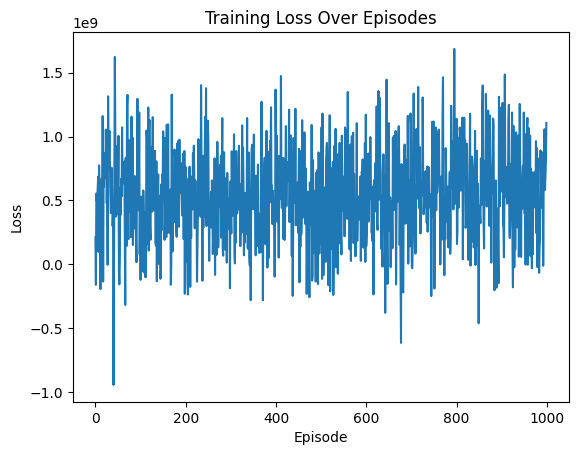

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Loss Over Episodes')
plt.show()

In [ ]:
torch.save(agent.state_dict(), 'rl_agent_model.pth')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
def test_model(env, agent, num_tests=5):
    for test in range(num_tests):
        state_quantities, state_products = env.reset()
        print(f"Test {test+1}:")
        done = False
        steps = 0

        while not done:  # Limit test steps
            state_tensor = torch.tensor(
            np.concatenate((state_quantities.flatten(), state_products.flatten())), 
            dtype=torch.float32
            ).to(device)
            with torch.no_grad():
                action_probs = agent(state_tensor)
            action = torch.argmax(action_probs).item()
            zone, anaquel, row_idx, col = np.unravel_index(action, state_quantities.shape)

            print(f"  Action {steps+1}: Zone {zone}, Anaquel {anaquel}, Row {row_idx}, Col {col}")

            (state_quantities, state_products), reward, done = env.step((zone, anaquel, row_idx, col))

        print("Final State Quantities:")
        print(state_quantities)

        print("Final State Products (IDs):")
        print(state_products)

test_model(env, agent)


Test 1:
  Action 1: Zone 4, Anaquel 1, Row 0, Col 5
  Action 1: Zone 7, Anaquel 3, Row 0, Col 1
  Action 1: Zone 3, Anaquel 3, Row 1, Col 4
  Action 1: Zone 7, Anaquel 3, Row 0, Col 4
  Action 1: Zone 5, Anaquel 1, Row 2, Col 1
  Action 1: Zone 3, Anaquel 1, Row 1, Col 3
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaquel 3, Row 1, Col 6
  Action 1: Zone 2, Anaq